In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score

In [2]:
df = pd.read_csv('../../data/processed/WESAD/data_processed/30s/all_data.csv', index_col=0)
df.head(10)

,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,...,hr_sdnn_ratio,acc_hr_slope_diff,sdnn_netacc_ratio,eda_hr_interaction,eda_resp_ratio,hr_resp_interaction,hrv_composite,hrv_stress_index,arousal_index,focus_label
0,53.356667,16.646000,22.310000,63.403083,3.464344,0.640051,0.042624,-0.001226,23.547401,3.927255,...,0.484254,3.603922,2.786436,54.757937,0.010853,2014.537539,122.855695,1.245035,1289.407069,1
1,54.384667,14.914000,23.598000,63.423202,2.527858,0.522190,0.027494,-0.000580,24.049974,3.610985,...,0.470618,1.264275,3.103511,48.372475,0.007614,2227.841975,184.537901,0.704795,1163.356764,1
2,55.673333,17.130000,22.103333,63.371988,1.759675,0.504689,0.013444,0.000012,23.252303,3.880405,...,0.473227,-0.742401,3.019624,45.702928,0.003465,2105.649261,177.633397,0.738724,1062.698301,1
3,50.268000,20.538000,26.323333,63.354186,2.607511,0.505930,0.016788,0.000090,22.749655,2.992443,...,0.448400,4.537308,3.124974,44.913563,0.005610,2019.584005,179.032540,0.762547,1021.768085,1
4,53.884667,13.176000,-20.754667,63.015126,1.203854,0.455631,0.021998,-0.000634,22.229279,6.140247,...,0.690826,7.844220,1.775132,35.209239,0.003583,1717.786631,92.813257,0.857373,782.676010,1
5,50.273333,25.046667,15.344000,63.379411,2.137492,0.390891,0.016305,-0.000458,21.609385,2.637111,...,0.605929,4.037823,2.212658,33.215446,0.006183,1836.227356,115.309797,0.948844,717.765359,1
6,53.982000,26.252000,17.136667,63.424968,0.871813,0.361442,0.014805,-0.000326,23.378201,4.010276,...,0.409805,-7.953004,3.652124,34.310077,0.003692,2219.187217,210.631554,0.718897,802.107854,1
7,54.366000,25.382000,20.492667,63.447958,0.413116,0.329505,0.016684,-0.000409,22.043036,2.176582,...,0.443754,-3.593902,3.302668,30.639888,0.007665,2049.730009,161.954025,1.003510,675.396167,1
8,44.229333,16.220667,-32.767333,63.142306,1.199372,0.281476,0.014150,-0.000311,24.014866,4.418985,...,0.458001,4.421966,3.059566,24.905113,0.003202,2124.842722,172.989547,0.753024,598.092956,1
9,42.374667,13.378667,-44.673333,63.016231,0.365034,0.242791,0.010291,-0.000257,21.259364,2.974239,...,0.443430,6.883157,2.861205,19.411452,0.003460,1699.715861,157.300446,0.788235,412.675119,1


In [3]:
focus_corr = df.corr()['focus_label'].drop(['focus_label', 'label', 'subject'])
top_features = focus_corr.abs().sort_values(ascending=False).head(17).index.tolist()
selected_columns =  top_features + ['subject', 'focus_label']

In [4]:
df_1 = df[selected_columns]
df_1.head(10)

,hr_resp_interaction,hr_center,hr_netacc_interaction,hr_zscore,HR,IBI,RESP_rate,EDA_std,eda_resp_ratio,arousal_index,eda_hr_interaction,EDA_mean,RESP_regularity,ACC_y_mean,EDA_slope,ACC_z_mean,hrv_stress_index,subject,focus_label
0,2014.537539,-4.075092,5424.288387,-0.386345,85.552438,754.407051,23.547401,0.042624,0.010853,1289.407069,54.757937,0.640051,3.927255,16.646000,-0.001226,22.310000,1.245035,2,1
1,2227.841975,3.006332,5875.136190,0.285020,92.633862,707.698171,24.049974,0.027494,0.007614,1163.356764,48.372475,0.522190,3.610985,14.914000,-0.000580,23.598000,0.704795,2,1
2,2105.649261,0.929061,5738.751225,0.088081,90.556591,714.939024,23.252303,0.013444,0.003465,1062.698301,45.702928,0.504689,3.880405,17.130000,0.000012,22.103333,0.738724,2,1
3,2019.584005,-0.853262,5624.221511,-0.080895,88.774268,735.156250,22.749655,0.016788,0.005610,1021.768085,44.913563,0.505930,2.992443,20.538000,0.000090,26.323333,0.762547,2,1
4,1717.786631,-12.351672,4869.547945,-1.171018,77.275859,798.986486,22.229279,0.021998,0.003583,782.676010,35.209239,0.455631,6.140247,13.176000,-0.000634,-20.754667,0.857373,2,1
5,1836.227356,-4.653924,5385.577191,-0.441222,84.973607,741.185897,21.609385,0.016305,0.006183,717.765359,33.215446,0.390891,2.637111,25.046667,-0.000458,15.344000,0.948844,2,1
6,2219.187217,5.297963,6020.646390,0.502281,94.925493,701.264881,23.378201,0.014805,0.003692,802.107854,34.310077,0.361442,4.010276,26.252000,-0.000326,17.136667,0.718897,2,1
7,2049.730009,3.360113,5899.876065,0.318560,92.987643,709.984756,22.043036,0.016684,0.007665,675.396167,30.639888,0.329505,2.176582,25.382000,-0.000409,20.492667,1.003510,2,1
8,2124.842722,-1.147224,5586.850578,-0.108764,88.480306,733.203125,24.014866,0.014150,0.003202,598.092956,24.905113,0.281476,4.418985,16.220667,-0.000311,-32.767333,0.753024,2,1
9,1699.715861,-9.676134,5038.235705,-0.917360,79.951397,801.649306,21.259364,0.010291,0.003460,412.675119,19.411452,0.242791,2.974239,13.378667,-0.000257,-44.673333,0.788235,2,1


In [5]:
X = df_1.drop(columns=['subject', 'focus_label'])
y = df_1['focus_label']
groups = df_1['subject']
subject_ids = sorted(groups.unique())

In [6]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

In [7]:
params = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.1, 1]
}

In [8]:
grid = GridSearchCV(pipe, param_grid=params, cv=5, scoring='precision')
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__gamma': ['scale', 0.1, 1]},
             scoring='precision')

In [9]:
best_params = grid.best_params_

In [10]:
print("Best precision:", grid.best_score_)
print("Best params:", grid.best_params_)

Best precision: 0.6893678016112
Best params: {'svm__C': 0.1, 'svm__gamma': 'scale'}


In [11]:
subject_pairs = list(combinations(subject_ids, 2))

In [12]:
f1_scores = []
precision_scores = []

In [13]:
for test_subjects in subject_pairs:
    test_mask = groups.isin(test_subjects)
    train_mask = ~test_mask

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(C=best_params['svm__C'], gamma=best_params['svm__gamma']))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    recall = precision_score(y_test, y_pred)

    f1_scores.append(f1)
    precision_scores.append(recall)

In [14]:
print("🔍 2-Subject Cross-Validation Summary (SVM)")
print(f"📌 Mean F1     = {np.mean(f1_scores):.3f}")
print(f"📌 Std F1      = {np.std(f1_scores):.3f}")
print(f"📌 Mean precision = {np.mean(precision_scores):.3f}")
print(f"📌 Std precision  = {np.std(precision_scores):.3f}")

🔍 2-Subject Cross-Validation Summary (SVM)
📌 Mean F1     = 0.725
📌 Std F1      = 0.186
📌 Mean precision = 0.706
📌 Std precision  = 0.221


In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

In [16]:
test_subjects = (3, 16)
test_mask = groups.isin(test_subjects)
train_mask = ~test_mask

In [17]:
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

In [18]:
base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=0.1, gamma='scale'))
])

In [19]:
model = CalibratedClassifierCV(estimator=base_model, method='sigmoid', cv=3)

In [20]:
model.fit(X_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('svm', SVC(C=0.1))]))

In [21]:
y_prob = model.predict_proba(X_test)[:, 1]

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_prec = average_precision_score(y_test, y_prob)

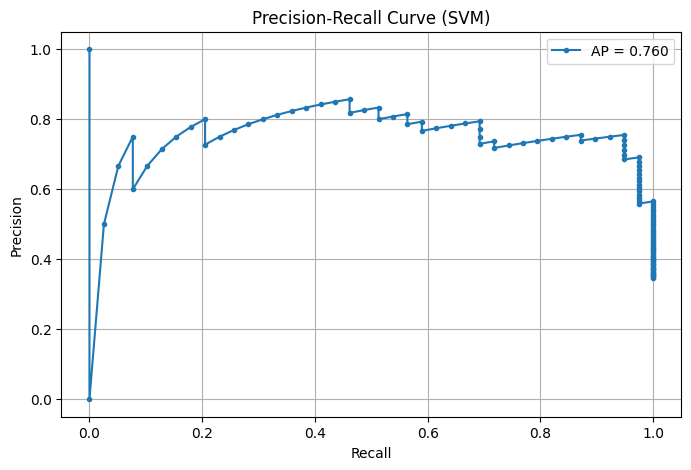

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, marker='.', label=f'AP = {avg_prec:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (SVM)')
plt.legend()
plt.grid(True)
plt.show()

## TabNet

In [24]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [25]:
subj_id = sorted(df_1['subject'].unique())

In [26]:
train_subj, test_subj = train_test_split(subj_id, test_size=3, random_state=42)

In [27]:
print("Train size:\t\t", len(train_subj))
print("Test size:\t\t", len(test_subj))

Train size:		 12
Test size:		 3


In [28]:
df_train = df_1[df_1['subject'].isin(train_subj)]
df_test = df_1[df_1['subject'].isin(test_subj)]

In [29]:
print(df_train['subject'].unique())
print(df_test['subject'].unique())

[ 3  4  5  6  7  8  9 10 13 15 16 17]
[ 2 11 14]


In [30]:
X_train, y_train = df_train[top_features], df_train['focus_label']
X_test, y_test = df_test[top_features], df_test['focus_label']

In [31]:
clf = TabNetClassifier()

/opt/homebrew/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [32]:
clf.fit(
    X_train.values, y_train.values,
)

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/opt/homebrew/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [33]:
preds = clf.predict(X_test.values)

In [35]:
clf.history

{'loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'lr': [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.

In [34]:
loss = clf.history['loss']
val_loss = clf.history['val_loss']

plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("TabNet Loss Curve")
plt.show()

KeyError: 'val_loss'

In [ ]:
print(clf.history)

{'loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'lr': [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02], 'val_auc': [np.float64(0.5245901639344263), np.float64(0.5245901639344263), np.float64(0.5245901639344263), np.float64(0.5245901639344263), np.float64(0.5245901639344263), np.float64(0.5245901639344263), np.float64(0.5245901639344263), np.float64(0.5245901639344263), np.float64(0.5245901639344263), np.float64(0.5245901639344263), np.float64(0.5245901639344263)]}
